In [1]:
from probe_experiment import *
from handcrafted_datasets import Dataset
from models import *
import torch
import torch.nn as nn
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
dataset = Dataset('surround', 'C:\\Users\\andre\\go-ai\\data', 0.8, 0.2, 1024)

def get_train_loader():
    dataset.shuffle('train')
    return dataset.loader('train', max_ram_files=25)

def get_test_loader():
    return dataset.loader('test', max_ram_files=25)

done loading data
split sizes:
train 552
test 138


In [3]:
go_model = load_go_model_from_ckpt('model_ckpt.pth.tar', rm_prefix=True)
feat_models = [CutModel(go_model, i).cuda() for i in range(8)]
n_channels = [8, 64, 64, 64, 48, 48, 32, 32]
probe_models = [nn.Sequential(nn.Conv2d(nc, 1, 19, padding=9), nn.Flatten()).cuda() for nc in n_channels]

In [4]:
for depth in range(8):
    checkpoint = torch.load('experiments/surround/surround_19x19cnn_d%d/best.ckpt' % depth, map_location=torch.device('cuda'))
    state_dict = checkpoint['state_dict']
    probe_models[depth].load_state_dict(state_dict)

In [5]:
aucs = []
for depth in range(8):
    feat_model = feat_models[depth]
    probe_model = probe_models[depth]
    exp = ProbeExperiment(get_train_loader, get_test_loader, feat_model)
    preds, labels = exp.get_predictions(probe_model, get_test_loader())
    auc = roc_auc_score(labels.flatten(), preds.flatten())
    aucs.append(auc)
    print(auc)

0.9863475701138898
0.9969218020813431
0.9937401577262357
0.9947033813037957
0.9849409017514535
0.948609273482293
0.8877608458112647
0.8278371074991652


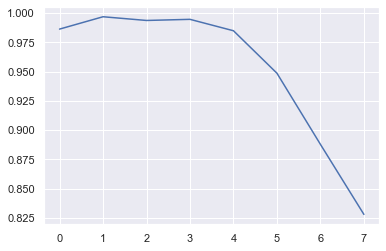

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
plt.plot(aucs)

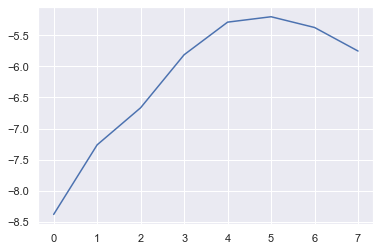

In [10]:
#last move probe results copied from tensorboard
losses = [-8.383, -7.263, -6.666, -5.813, -5.288, -5.201, -5.374, -5.753]
plt.plot(losses)